In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

a)

In [3]:
def extractdata(classification):
    " extract the  data given the path "
    data  = pd.read_csv(classification,sep = ' ', header=None, engine='python')
    X = data.as_matrix()[:,0:2]
    return X

In [4]:
X = extractdata('classification_data_HWK2/EMGaussian.data')

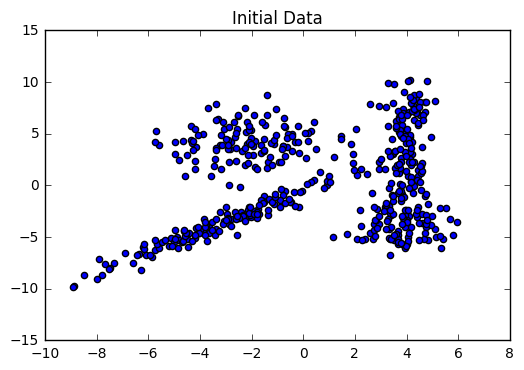

In [5]:
plt.scatter(X[:,0],X[:,1])
plt.title('Initial Data')
plt.show()


In [6]:
def KMeans(X,C0,Niter):
    """
    Computes the labels of a given distribution using K-means algorithm
    
    Parameters
    ----------
        X : Array containing datapoints
        C0 : Array containing initial centroids
        Niter : Number of iterations to run
    Returns
    -------
        labels: label[i] is the label of the i-th observation X[i]
        classes: classes[k] contains the data points that have the class k
    """
    
    k = np.shape(C0)[0] #number of clusters = number of initial centroids
    C = C0 #Centroids
    ## Compute initial classes
    labels = []
    classes = [[] for i in range(k)]
    for x in X:
        for i,c in enumerate(C0):
            if(i == 0):
                distMin = np.sqrt(np.dot(x-c,x-c))
                label = i
            else:
                dist = np.sqrt(np.dot(x-c,x-c))
                if(dist < distMin):
                    distMin = dist
                    label = i
                
        labels += [label]
        classes[label] += [x] 
    
    ## Iterate 
    for t in range(Niter):
        # Update centroids
        C = np.array([np.mean(c,axis = 0) for c in classes])
        # Update classes
        labels = []
        classes = [[] for i in range(k)]
        for x in X:
            for i,c in enumerate(C):
                if(i == 0):
                    distMin = np.sqrt(np.dot(x-c,x-c))
                    label = i
                else:
                    dist = np.sqrt(np.dot(x-c,x-c))
                    if(dist < distMin):
                        distMin = dist
                        label = i

            labels += [label]
            classes[label] += [x] 
##Labels[i]  is the label of the ith observation
##classes[k] is the set of observation with class k
    return labels, classes
              

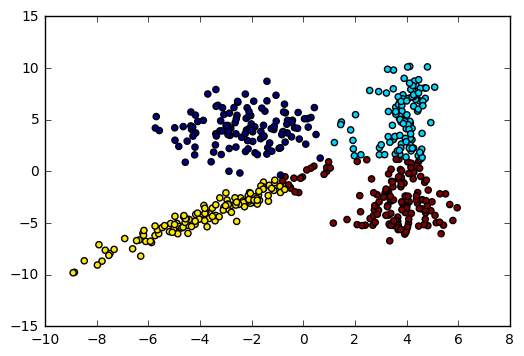

In [7]:
def random_uniform(k):
    """ 
    Returns k points picked uniformly at random on the smallest rectangle containing all the observations
    """
    x0 = np.random.uniform(np.amin(X[:,0]),np.amax(X[:,0]) , k)
    y0 = np.random.uniform(np.amin(X[:,1]),np.amax(X[:,1]) , k)
    C0 = np.array([[x0[i],y0[i]] for i in range(k)])
    return C0

C0 = random_uniform(4) 
labels,classes = KMeans(X,C0,1000) 
plt.scatter(X[:,0],X[:,1],c=labels)
plt.show()

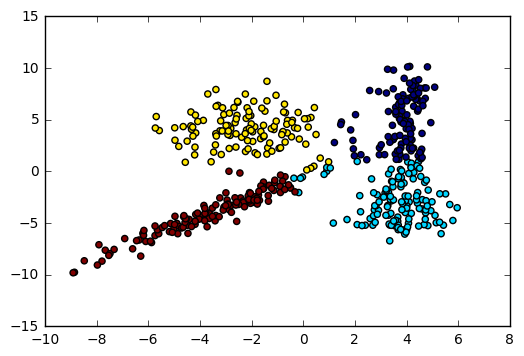

In [8]:
def random_select(k):
    """
    Selects k random points among the observations
    """
    i = np.random.randint(np.shape(X)[0],size = k)
    return X[i]

C0 = random_select(4)
labels,classes = KMeans(X,C0,1000)
plt.scatter(X[:,0],X[:,1],c=labels)
plt.show()

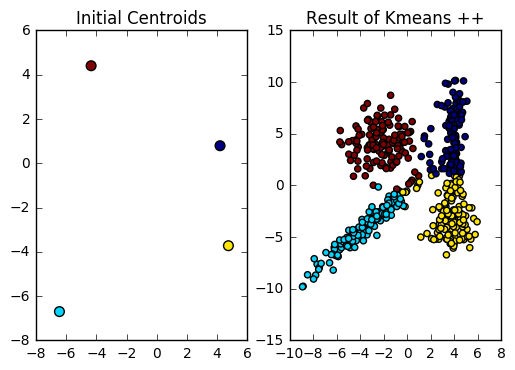

In [9]:
def plusplus(k):
    # First center, chosen uniformly at random 
    
    j = np.random.randint(np.shape(X)[0],size = 1)
    C = X[j]
    # Terminates if k = 1
    
    for t in range(k-1):
    # For each point , compute the distance to the closest center already selected
        d = []
        for x in X:
            for j,c in enumerate(C):
                # Initialize minimum distance
                if j == 0:
                    min_dist = np.dot(x-c,(x-c).T)
                else:
                    dist = np.dot(x-c,(x-c).T)
                    if(dist<min_dist):
                        min_dist = dist
            d += [min_dist]
            
        #  Probabilities for each of being the next centroid
        d = np.array(d/np.sum(d))
        # Selects new centroid at random bas on the distribution computed before
        new_i = np.random.choice(np.shape(X)[0] , p = d)
        C = np.vstack((C,X[new_i]))
        
    return C

k = 4
C0 = plusplus(k)
labels = range(k)
f,(ax1,ax2) = plt.subplots(1,2)
ax1.scatter(C0[:,0],C0[:,1],c=labels,s = 49)
ax1.set_title('Initial Centroids')
labels,classes = KMeans(X,C0,100)
ax2.scatter(X[:,0],X[:,1],c=labels)
ax2.set_title('Result of Kmeans ++')


b)
Let's denote our observations $x = (x_1, ... ,x_n)$, the set of classes $(C_1,...,C_K)$ and some hidden variables $z = (z_1,...,z_n)$ where we assume that:

-The distribution of $z$ is multinomial with parameters $(\pi_1,...,\pi_K)$.

-The dstribution of $(x|z = j)$ is $\mathcal{N}(\mu_j,\sigma_j I)$.

For the EM algorithm we need to initialize $\theta_0$, then repeat the following:

-Do the expectation step : $ \forall i = 1, ..., n ,\forall j = 1,...,K,$
$$q_{t+i}(j) = p_{\theta_t}(z = j|x_i) = \frac{\pi_j \mathcal{N}(\mu_j,\sigma_j I)}{\displaystyle{\sum_{j' = 1}^{K} {\pi_j' \mathcal{N}(\mu_j',\sigma_j' I)}}} \triangleq \tau_i^j $$

-Do the maximization step :
Find $\pi_j$, $\mu$ and $\sigma$ that maximize

$$
\sum_{i = 1}^n{\sum_{j = 1}^K{\tau_i^j log(\pi_j)}} +\sum_{i = 1}^n{\sum_{j = 1}^K{\tau_i^j ( log( \frac{1}{(2\pi)^{ \frac{p}{2} }} ) + log(\frac{1}{(\sigma^2)^{p/2}}) - \frac{1}{2} \frac{(x_i-\mu_j)^T(x_i-\mu_j)}{\sigma^2} ) }}
$$

By setting the gradients to zero we find :

$$\mu_{j,t+1} = \displaystyle{\frac{\sum_i{\tau_i^j x_i}}{\sum_i{\tau_i^j}}}$$

$$\sigma_{j,t+1} = \displaystyle{\frac{\sum_i{\tau_i^j (x_i - \mu_{j,t+1})^T(x_i - \mu_{j,t+1})}}{p \sum_i{\tau_i^j}}}$$
where $p$ is the dimension of the observations (in our problem $p = 2$).


In [10]:
# Definition of the gaussian density function with isotropic covariance matrix
def gauss(x,mu,sigma):
    n = np.shape(x)[0]
    f = (1.0/np.sqrt((2*np.pi*sigma)**n)) * np.exp(-(1.0/(2*sigma))*np.dot(x-mu,x-mu)) 
    return f

# Definition of the update function of the expectation step
def tau(i,j,pi,mu,sigma):
    K = np.shape(pi)[0] # Number of classes
    num = pi[j]*gauss(X[i],mu[j],sigma[j])
    denom = np.sum([pi[j]*gauss(X[i],mu[j],sigma[j]) for j in range(K)])
    return num/denom

def EM_Iso(K,Niter):
    """
    Parameters
    ----------
        K : number of classes
        Niter : number of iterations
        
    Returns
    ------- 
        mu : Array containing the means of each class
        sigma : Array containing the standard deviations of each class
    """
    
    n,p = np.shape(X)
    #Initialization
    pi0 = np.ones(K)*(1.0/K)
    i = np.random.randint(n,size = K) # Pick k data points at random to initialize the centroids
    mu0 = X[i]
    sigma0 = np.ones(K)
    
    
    pi = pi0
    mu = mu0
    sigma = sigma0
    q = (1.0/K)*np.ones(shape = (n,K)) # Matrix of Membership weights
    #EM Loop
    labels = range(K)
    t = 0
    while (t < Niter):
        # E-step
        for i,x in enumerate(X):
            for j in range(K):
                    q[i][j] = tau(i,j,pi,mu,sigma)
            
                    
        # M-step
        for j in range(K):
            pi[j] = np.mean(q[:,j])
            mu[j] = np.dot(q[:,j],X)/np.sum(q[:,j])
            sigma[j] = np.sum([q[i][j] * np.dot(X[i] - mu[j],X[i] - mu[j]) for i in range(n)])/(p*np.sum(q[:,j]))
        t +=1
    return mu,sigma

In [13]:
k = 4
mu,sigma = EM_Iso(4,100)

In [14]:
sigma

array([ 2.20212618,  0.5297467 ,  1.35488728,  8.99802545])

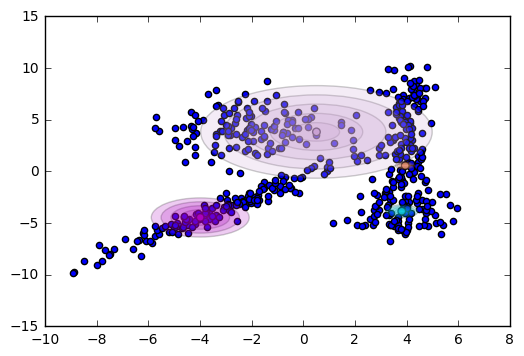

In [258]:
fig, ax = plt.subplots() 
ax.scatter(X[:,0],X[:,1])
colors = np.random.rand(k,3)
ax.scatter(mu[:,0],mu[:,1],c = colors,s = 30)
for t in range(5):
    ellipses = [Ellipse(xy = mu[i],width = sigma[i]*(t+1)/5,height = sigma[i]*(t+1)/5) for i in range(k)]
    for i,e in enumerate(ellipses):
        ax.add_artist(e)
        e.set_facecolor(colors[i])
        e.set_alpha(0.2)

c) 
Let's denote our observations $x = (x_1, ... ,x_n)$, the set of classes $(C_1,...,C_K)$ and some hidden variables $z = (z_1,...,z_n)$ where we assume that:

-The distribution of $z$ is multinomial with parameters $(\pi_1,...,\pi_K)$.

-The dstribution of $(x|z = j)$ is $\mathcal{N}(\mu_j,\Sigma_j)$.

For the EM algorithm we need to initialize $\theta_0$, then repeat the following:

-Do the expectation step : $ \forall i = 1, ..., n ,\forall j = 1,...,K,$
$$q_{t+1}(j) = p_{\theta_t}(z = j|x_i) = \frac{\pi_j \mathcal{N}(\mu_j,\Sigma_j )}{\displaystyle{\sum_{j' = 1}^{K} {\pi_j' \mathcal{N}(\mu_j',\Sigma_j' )}}} \triangleq \tau_i^j $$

-Do the maximization step :
Find $\pi_j$, $\mu$ and $\sigma$ that maximize

$$
\sum_{i = 1}^n{\sum_{j = 1}^K{\tau_i^j log(\pi_j)}} +\sum_{i = 1}^n{\sum_{j = 1}^K{\tau_i^j ( log( \frac{1}{(2\pi)^{ \frac{p}{2} }} ) + log(\frac{1}{(\sigma^2)^{p/2}}) - \frac{1}{2} (x_i-\mu_j)^T\Sigma^{-1}(x_i-\mu_j) ) }}
$$
where $p$ is the dimension of the observations (in our problem $p = 2$).


By setting the gradients to zero we find :

$$\mu_{j,t+1} = \displaystyle{\frac{\sum_i{\tau_i^j x_i}}{\sum_i{\tau_i^j}}}$$

$$\sigma_{j,t+1} = \displaystyle{\frac{\sum_i{\tau_i^j (x_i - \mu_{j,t+1})(x_i - \mu_{j,t+1})^T}}{ \sum_i{\tau_i^j}}}$$


In [15]:
# Definition of the gaussian density function with non isotropic covariance matrix
def gaussNonIso(x,mu,S):
    n = np.shape(x)[0]
    Sinv = np.linalg.pinv(S)
    det = np.linalg.det(S)
    tmp = np.dot((x-mu),np.dot(Sinv,x-mu))
    f = (1.0/np.sqrt((2*np.pi*det)**n)) * np.exp(-(1.0/(2))*np.dot((x-mu).T,np.dot(Sinv,x-mu))) 
    return f

# Definition of the update function of the weights in the expectation step
def tauNonIso(i,j,pi,mu,sigma):
    """
    Computes the weight
    Parameters
    ----------
    i : index of observation
    j : index of  class
    pi : distribution of z
    mu : means of the distributions of x given z
    sigma : covariance matrices of the distributions of x given z
    
    Returns
    -------
    Value of the weight of th
    """
    K = np.shape(pi)[0] # Number of classes
    num = pi[j]*gaussNonIso(X[i],mu[j],sigma[j])
    denom = np.sum([pi[j]*gaussNonIso(X[i],mu[j],sigma[j]) for j in range(K)])
    return num/denom

# Definition of the update function of the covariance matrix for the maximization step
def updatesigma(j,q,mu):
    """
    Parametesr"""
    res = 0
    for i,elt  in enumerate(q[:,j]):
        tmp1 = np.outer(X[i] - mu[j],X[i] - mu[j])
        res += q[i][j]*tmp1
    res /= np.sum(q[:,j])
    
    return res
def GMM(X,K,Niter):
    """
    Parameters
    ----------
        X : Observations
        K : number of classes
        Niter : number of iterations
        
    Returns
    ------- 
        mu : Array containing the means of each class
        sigma : Array containing the standard deviations of each class
    """
    
    n,p = np.shape(X)
    #Initialization
    pi0 = np.random.rand(K)
    pi0 /= np.sum(pi0)
    
    i = np.random.randint(n,size = K) # Pick k data points at random to initialize the means of the gaussians
    mu0 = X[i]
    
    sigma0 = np.zeros(shape = (K,p,p))
    
    for j in range(K):
        sigma0[j] = (j+1)*np.identity(p)
        
    pi = pi0
    mu = mu0
    sigma = sigma0
    q = np.random.rand(n,K)# Matrix of Membership weights
    #EM Loop
    labels = range(K)
    t = 0
    while (t < Niter):
        # E-step
        for i,x in enumerate(X):
            for j in range(K):
                    q[i][j] = tauNonIso(i,j,pi,mu,sigma)
        # M-step
        for j in range(K):
            pi[j] = np.mean(q[:,j])
            mu[j] = np.dot(q[:,j],X)/np.sum(q[:,j])
            
            sigma[j] = updatesigma(j,q,mu)
        t += 1
        
    return mu,sigma


In [1]:
k = 4
mu,sigma = GMM(X,k,100)

NameError: name 'EM' is not defined

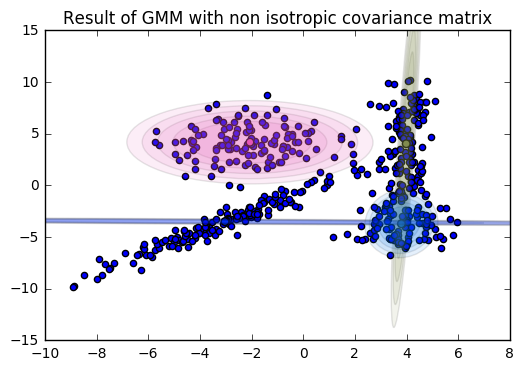

In [253]:
fig, ax = plt.subplots() 
ax.scatter(X[:,0],X[:,1])
colors = np.random.rand(k,3)
ax.scatter(mu[:,0],mu[:,1],c = colors,s = 30)
ellipses = [[] for i in range(k)]

for j in range(k):
    for t in range(5):
        eigval,eigvect = np.linalg.eig(sigma[j])
        w,h = eigval
        i = np.argmax(eigval)
        v = eigvect[i]
        theta = np.arctan(v[1]/v[0])
        ellipses[j].append(Ellipse(xy = mu[j],width = w*2*(t+4)/5,height = h*2*(t+4)/5,angle = theta))
    for e in ellipses[j]:
        ax.add_artist(e)
        e.set_facecolor(colors[j])
        e.set_alpha(0.1)
ax.set_title('Result of GMM with non isotropic covariance matrix')

In [ ]:
fig, ax = plt.subplots() 
ax.scatter(X[:,0],X[:,1])


In [17]:
sigma = np.array([[[  6.36052388,   6.18082784],
        [  6.18082784,   6.32738957]],

       [[  0.20812237,   0.22814132],
        [  0.22814132,  11.11142786]],

       [[  0.88553325,   0.05396892],
        [  0.05396892,   2.05232288]],

       [[  2.8042089 ,   0.22192863],
        [  0.22192863,   2.6946592 ]]])

array([[[  6.36052388,   6.18082784],
        [  6.18082784,   6.32738957]],

       [[  0.20812237,   0.22814132],
        [  0.22814132,  11.11142786]],

       [[  0.88553325,   0.05396892],
        [  0.05396892,   2.05232288]],

       [[  2.8042089 ,   0.22192863],
        [  0.22192863,   2.6946592 ]]])

In [18]:
mu = np.array([[-3.03086617, -3.50058694],
       [ 3.98609282,  4.03525452],
       [ 3.79801919, -3.70723762],
       [-2.06471094,  4.18252167]])


array([[-3.03086617, -3.50058694],
       [ 3.98609282,  4.03525452],
       [ 3.79801919, -3.70723762],
       [-2.06471094,  4.18252167]])